In [13]:
from readin import *
from scipy.stats import ttest_ind as ttest
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


In [14]:
FILE = "proteinGroups_Slavov_simplified.txt"
file_keyword="Slavov_Human_120min_as10plex"

technical_replicates = {
    "Cell line 1 Slavov":[0,1,4],
    "Cell line 2 Slavov":[2,3,7],
    "Cell line measurements 9&10":[8,9]
} #""" #As best I can figure for Slavov



FILE = "proteinGroups_MS3_simplified.txt"
file_keyword=""#Slavov_Human_120min_as10plex"

technical_replicates = {
    "Cell Line 1":[0,1,2],
    "Cell Line 2":[3,4,5],

    "Cell Line 3":[6,8]
} 


In [15]:
FOLD_CHANGE_THRESHOLD = 2 #only full doublings
#FOLD_CHANGE_THRESHOLD = 1.385788610020677 # at 99%
#FOLD_CHANGE_THRESHOLD = 1.1993359755806285 # at 95%
#These cuttoffs comes from the Standard Deviations page
#This indicates that anything greater than a 38% increase is important
P_VAL = .05

In [18]:
ms3data = readin(FILE)
negCont = ms3data.iloc[:,6].values
approxZeroRaw = mean(negCont)
stdevBlankRaw = stdev(negCont)
min_thresholdRaw = stdevBlankRaw+approxZeroRaw
print ('Zero Approximation',approxZeroRaw,'\nStdev of Negative Control',stdevBlankRaw)
print (min_thresholdRaw)

print("\nLogged Values: ")
ms3data = (np.log(ms3data)).replace(-np.inf, 0)
negCont = ms3data.iloc[:,6].values
approxZero = mean(negCont)
min_threshold = math.log(min_thresholdRaw)

print (approxZero)
print (min_threshold)

Zero Approximation 1568.8972232893157 
Stdev of Negative Control 3360.652877226167
4929.550100515483

Logged Values: 
4.198760752010342
8.503003005370585


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


# Variance Between Cell Lines

In [19]:
ms3Samples = {}

for sample in technical_replicates:
    #
    reps = {}
    sample_proteins = {}
    for rep in technical_replicates[sample]:
        reps[ms3data.iloc[:,rep].name] = ms3data.iloc[:,rep]
    ms3Samples[sample] = pd.DataFrame.from_dict(reps, dtype = float)
        
    for r in range(0, len(list(reps.values())[0])):
        rep_for_protein = []
        p = ms3data.iloc[r].name
        for rep in reps.values():
            if rep[r] > 0: rep_for_protein.append(rep[r])
        if len(rep_for_protein) > 1: 
            sample_proteins[p] = mean(rep_for_protein)
        else: sample_proteins[p] = 0.0
    

sample_names = list(technical_replicates.keys())

##### These are the same loops as below, to compare all lines to all lines without duplicates\n",
    "for i in range(0,len(sample_names)-1):\n",
    "\n",
    "    for o_ser_index in range(i+1,len(sample_names)):\n",
    "\n",
    "        print (i, o_ser_index)"

#The t test should have at least two non-identical values.

In [20]:
t_stats = {}
fold_changes = {}
c12, c22, c11, c21, c10,c20 = 0,0,0,0,0,0

for ser_index in range(0,len(sample_names)-1): #these are the keys to ms3Samples
    ser = sample_names[ser_index]
    sample_df1 = ms3Samples[ser]
    for o_ser_index in range(ser_index+1,len(sample_names)): #keys again
        o_ser = sample_names[o_ser_index]
        #compare variance in sample versus otherSample
        sample_df2 = ms3Samples[o_ser]
        for protein in sample_df1.index:
            tl1 = sample_df1.loc[protein,:]
            tl2 = sample_df2.loc[protein,:]
            
            # if the full set is zero
            if len([x for x in tl1 if x > min_threshold]) == 0: 
                c10 +=1
                tl1 = [approxZero,0]
            if len([x for x in tl2 if x > min_threshold]) == 0: 
                c20 +=1
                tl2 = [approxZero,0]
            
                
            #if one non-null - 
            #A. leave those alone it'll be basically zero anyway
            if (len([x for x in tl1 if x > min_threshold])) ==1: c11+=1
            if (len([x for x in tl2 if x > min_threshold])) ==1: c21+=1
            #or B. toss it?
            if (len([x for x in tl1 if x > min_threshold])) ==1: tl1 = [approxZero,0]
            if (len([x for x in tl2 if x > min_threshold])) ==1: tl2 = [approxZero,0]
            
                
            #if two good and one ~null, use only two good
            if (len([x for x in tl1 if x > min_threshold])) ==2:
                tl1 = [x for x in tl1 if x > min_threshold]
                c12+=1
            if (len([x for x in tl2 if x > min_threshold])) ==2:
                tl2 = [x for x in tl2 if x > min_threshold]
                c22+=1
                
                
            m1 = mean(tl1)
            m2 = mean(tl2)
                
            fold_changes[((ser,o_ser),protein)] = m2/m1
            
            
            s =ttest(tl1,tl2)
            t_stats[((ser,o_ser),protein)] = s

In [21]:
if len(technical_replicates) ==2:
    print (c10)
    print (c11)
    print (c12)
    print ()
    print (c20)
    print (c21)
    print (c22)

In [22]:
c = 0
for p in t_stats.values():
    i = p[1]
    if not (i < 0) and not (i == 0) and not (i > 0):
        c += 1
print (c,'NaN out of',(len(t_stats.values())))

0 NaN out of 2499


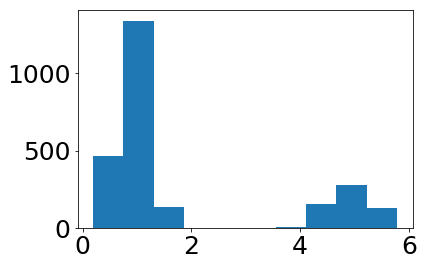

In [23]:
plt.hist(fold_changes.values())#, [1 for x in t_stats.values()])
plt.show()

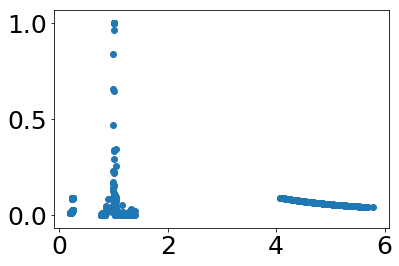

In [24]:
#Volcano Graph
plt.scatter(fold_changes.values(), [x[1] for x in t_stats.values()])
plt.show()

    "##### Log-Normalized Technical Variance Thresholds\n",
    "###### Ignoring Zeros: \n",
    "###### 95% threshold:  0.2601427941399485\n",
    "###### 99% threshold:  0.5243715339788084"

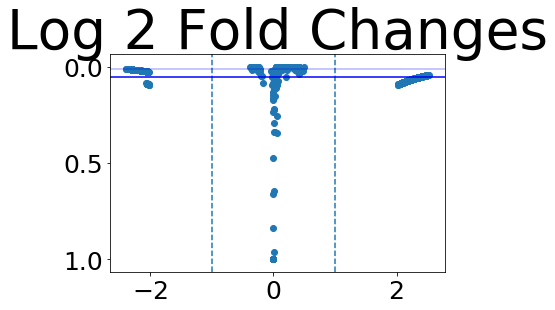

In [25]:
#Volcano Graph
plt.title("Log 2 Fold Changes")
log2_fold_changes = [x if x == 0 else math.log2(x) for x in fold_changes.values()]
p_values = [x[1] for x in t_stats.values()]
plt.scatter(log2_fold_changes, p_values)
plt.axvline(x= math.log2(FOLD_CHANGE_THRESHOLD), linestyle='dashed')
plt.axvline(x=-math.log2(FOLD_CHANGE_THRESHOLD), linestyle='dashed')
plt.axhline(y=.05, color='b', linestyle='-')
plt.axhline(y=.01, color='b', linestyle='-',alpha=.3)
plt.gca().invert_yaxis()
plt.show()


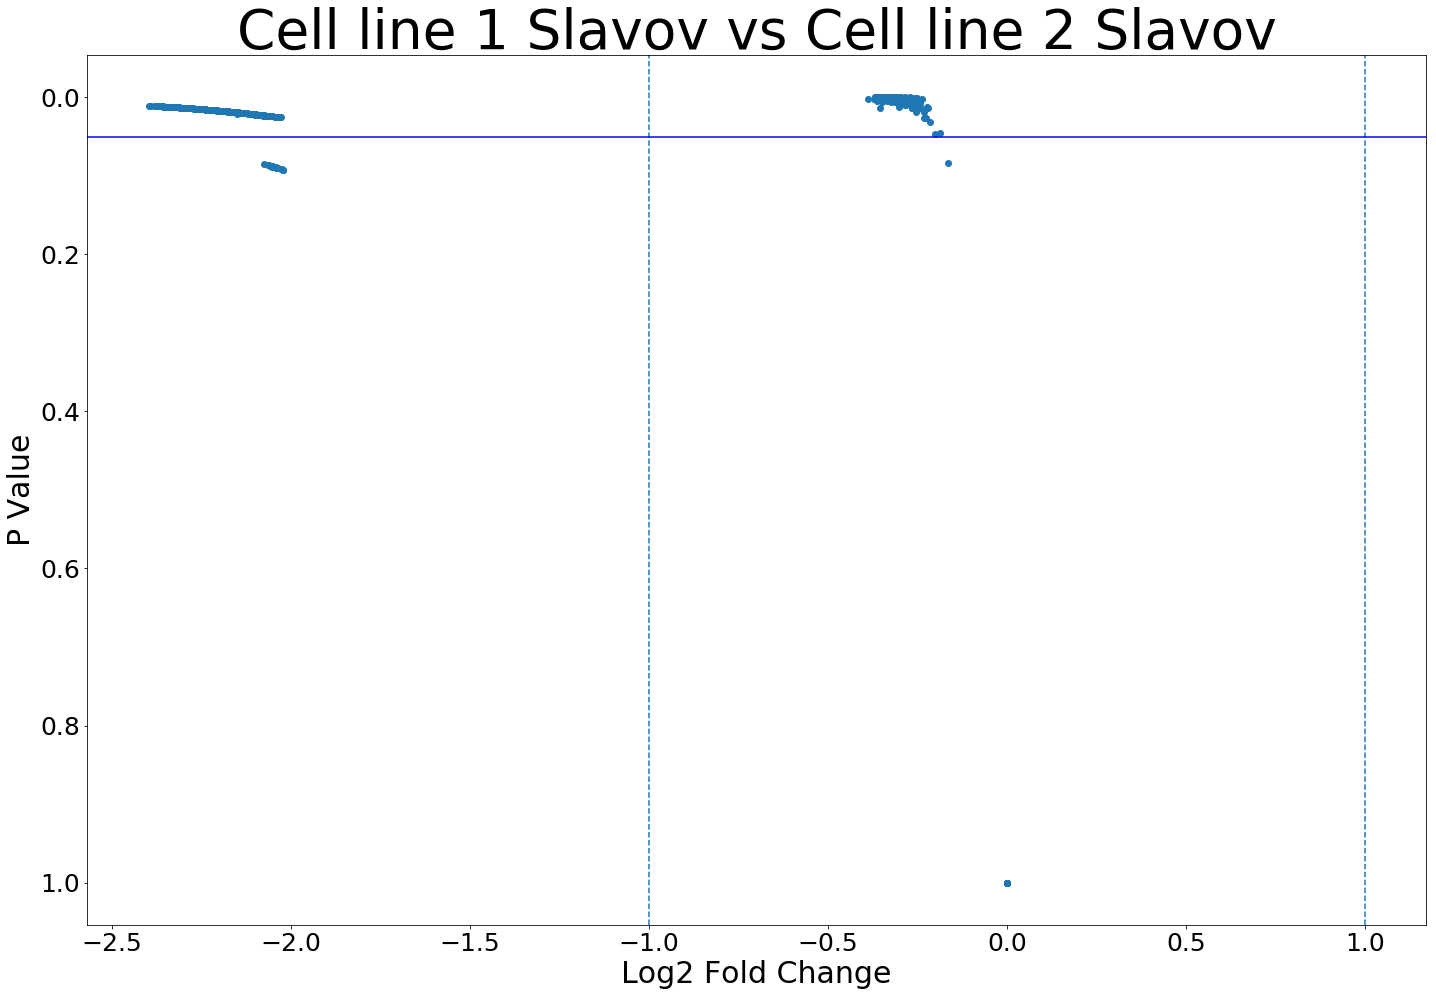

Using a 2 fold change threshold
443 proteins change significantly, out of 833 (53.18%)
0 proteins are upregulated, out of 833 (0.00%)
443 proteins are downregulated, out of 833 (53.18%)



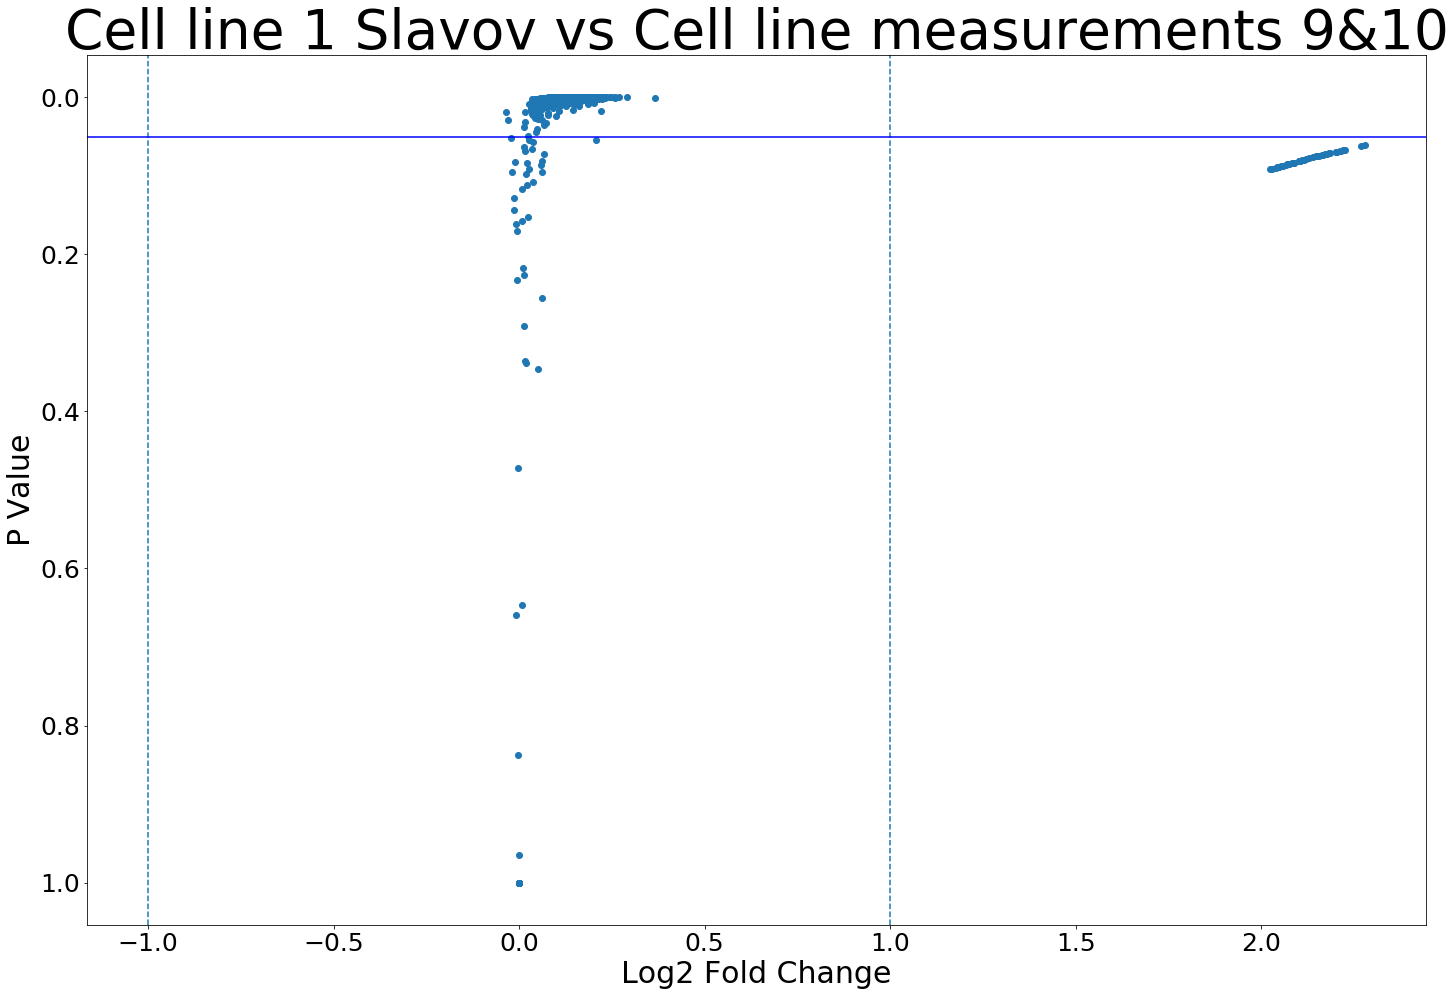

Using a 2 fold change threshold
0 proteins change significantly, out of 833 (0.00%)
0 proteins are upregulated, out of 833 (0.00%)
0 proteins are downregulated, out of 833 (0.00%)



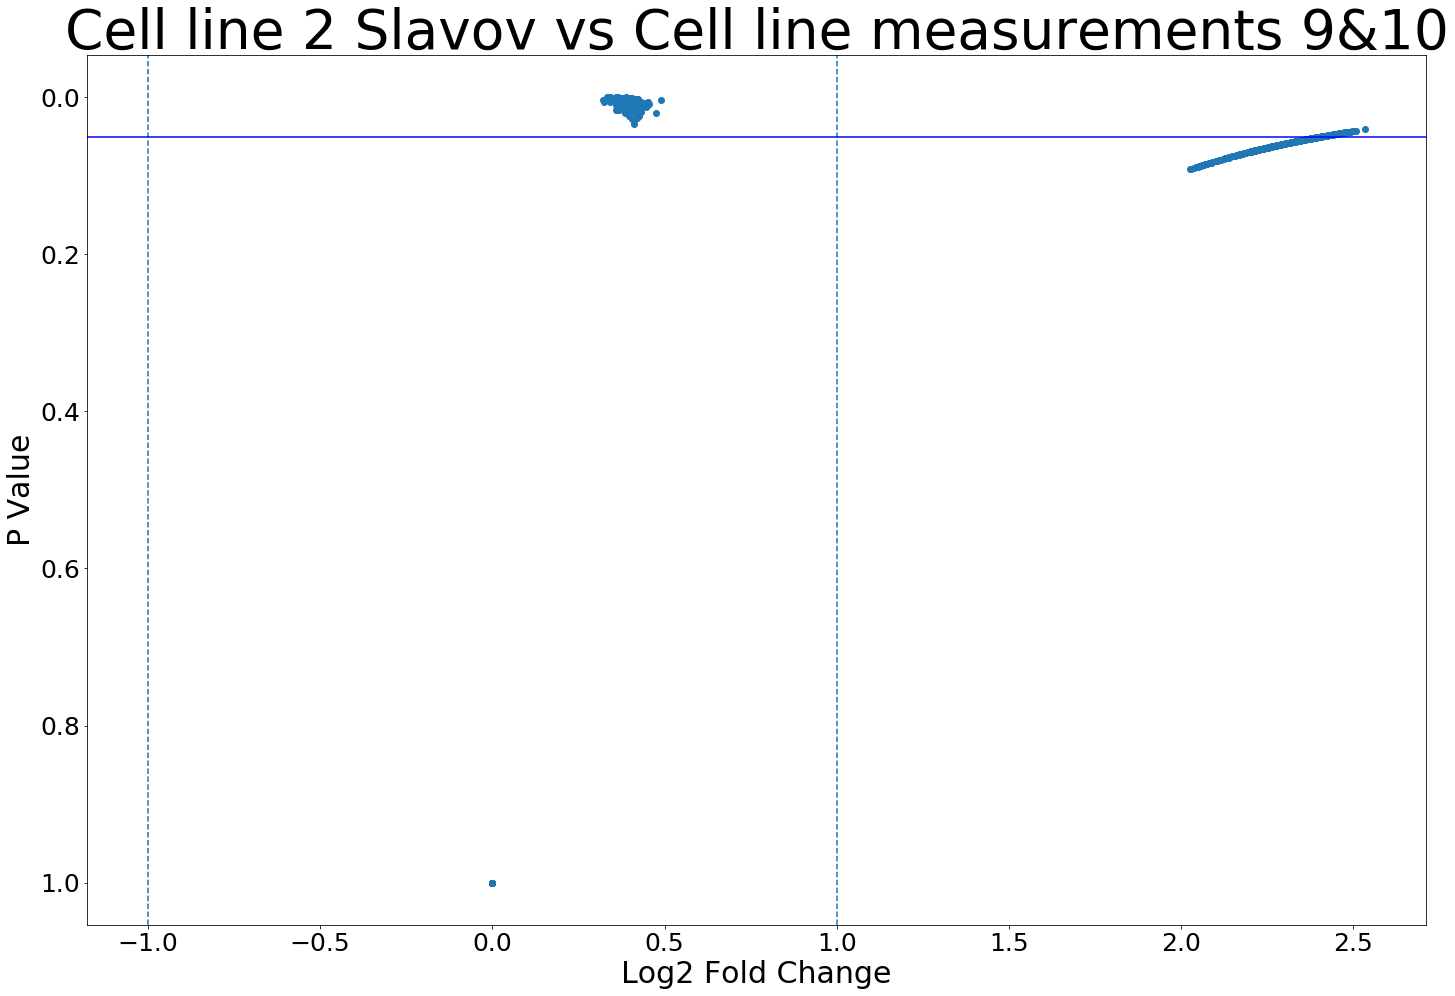

Using a 2 fold change threshold
93 proteins change significantly, out of 833 (11.16%)
93 proteins are upregulated, out of 833 (11.16%)
0 proteins are downregulated, out of 833 (0.00%)


In [26]:
REPORT_ALL=False
for ser_index in range(0,len(sample_names)-1): 
    ser = sample_names[ser_index]
    for o_ser_index in range(ser_index+1,len(sample_names)):
        print()
        o_ser = sample_names[o_ser_index]
        svo_fc = {x:fold_changes[x] for x in fold_changes if x[0] == (ser,o_ser)}
        svo_var = {x:t_stats[x][1] for x in t_stats if x[0] == (ser,o_ser)}
        
        log2_fold_changes = [x if x == 0 else math.log2(x) for x in svo_fc.values()]
        #fig = plt.figure(figsize=(12,8))
        fig, ax = plt.subplots() 
        fig.set_figheight(16)
        fig.set_figwidth(24)
        
        plt.title(ser+" vs "+o_ser)
        plt.scatter(log2_fold_changes, svo_var.values())
        
        plt.axvline(x=  math.log2(FOLD_CHANGE_THRESHOLD), linestyle='dashed')
        plt.axvline(x= -math.log2(FOLD_CHANGE_THRESHOLD), linestyle='dashed')
        #plt.axvline(x=  1.75, linestyle='dotted', alpha=.4)
        #plt.axvline(x= -2, linestyle='dotted', alpha=.4)
        plt.axhline(y=P_VAL, color='b', linestyle='-')
        #plt.axhline(y=threshold99, color='b', linestyle='dotted', alpha=.4)
        plt.gca().invert_yaxis()
        
        plt.rc('axes', titlesize=55)
        plt.rc('axes', labelsize=30)

        plt.rc('xtick', labelsize=25)
        plt.rc('ytick', labelsize=25) 
        plt.xlabel("Log2 Fold Change")
        plt.ylabel("P Value")
        
        #axins = zoomed_inset_axes(ax, 2, loc=3) 
        #axins.scatter(log2_fold_changes, svo_var.values())
        #axins.set_xlim(-4, -3) # apply the x-limits
        #axins.set_ylim(-0.01, 0.05)
        #axins.xaxis.set_visible(False)
        #axins.yaxis.set_visible(False)
        #axins.invert_yaxis()
        #mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5")
        
        fig_name = str('figures/Slavov/P_FC'+ser+' vs '+o_ser+'_'+file_keyword+'.jpeg')
        #fig.savefig(fig_name, dpi=300)
        plt.show()
        
        weirdpoints = []
        up_reg_points = []
        down_reg_points = []
        for key in fold_changes:
            if t_stats[key][1] < P_VAL:
                if key[0] == ((ser,o_ser)):
                    if fold_changes[key] > FOLD_CHANGE_THRESHOLD:
                        weirdpoints.append(key)
                        up_reg_points.append(key)
                    elif fold_changes[key] < 1/FOLD_CHANGE_THRESHOLD:
                        weirdpoints.append(key)
                        down_reg_points.append(key)
            
        line_category_counts = {}#Example key = "Cell Line1 vs Cell line 2" value = number of occurances
        protein_category_counts = {}#Name:Frequency
        for key in weirdpoints:
            line_category = (key[0][0]+" vs "+key[0][1])
            if line_category in line_category_counts:
                line_category_counts[line_category] += 1
            else: line_category_counts[line_category] = 1
    
            protein = key[1]
            if protein in protein_category_counts:
                protein_category_counts[protein] += 1
            else:protein_category_counts[protein] = 1
                
        print ("Using a {0} fold change threshold".format(FOLD_CHANGE_THRESHOLD))
        
        print ("{0} proteins change significantly, out of {1} ({2:.2f}%)"
               .format(len(protein_category_counts), ms3data.shape[0], 100*len(protein_category_counts)/ms3data.shape[0]))
        
        print ("{0} proteins are upregulated, out of {1} ({2:.2f}%)"
               .format(len(up_reg_points), ms3data.shape[0], len(up_reg_points)/ms3data.shape[0]*100))
        print ("{0} proteins are downregulated, out of {1} ({2:.2f}%)"
               .format(len(down_reg_points), ms3data.shape[0], len(down_reg_points)/ms3data.shape[0]*100))
        
        if REPORT_ALL==True:
            print("\nProtein\t\t  Fold Change\t\t Variance\n")
            for key in weirdpoints:
                print (key[1],"\t{0:.4f}".format(math.log2(fold_changes[key])),
                       "\t{0:.4f}".format(variances[key]))